# Wasserstein GAN

GAN is notorious for unstable training. Recall that in GAN, we optimize over the Jensen-Shannon divergence between the data distribution $\mathbb{P}_{data}$ and the generator distribution $\mathbb{P}_{g}$. 

$$
\begin{align*}
V(G, D) &= - \log(4) + JS(\mathbb{P}_{data}, \mathbb{P}_{g})\\
&= - \log(4) + D_{KL}(\mathbb{P}_{data}||\frac{\mathbb{P}_{data}+\mathbb{P}_{g}}{2}) + D_{KL}(\mathbb{P}_{g}||\frac{\mathbb{P}_{data}+\mathbb{P}_{g}}{2})
\end{align*}$$

In 2017, Arjovsky et al observes that Jensen-Shannon divergence does not have good theoretically properties and instead proposes another metric for measuring the distance between two distributions: the Earth Mover (EM) or Wasserstein distance

$$W(\mathbb{P}_r|\mathbb{P}_g) = \inf_{\gamma \in \Pi(\mathbb{P}_r, \mathbb{P}_g)} \mathbb{E}_{(x, y)\sim \gamma}[\|x-y\|]$$

Where $\Pi(\mathbb{P}_r, \mathbb{P}_g)$ denote the set of all joint probability distributions whose marginals are $\mathbb{P}_r$ and  $\mathbb{P}_g$, respectively. Informally, we can interpret the EM distance as the amount of "mass" that must be transported from $x$ to $y$ in order to transform the distribution $\mathbb{P}_r$ to $\mathbb{P}_g$. When $\mathbb{P}_r=\mathbb{P}_g$, no mass is needed to be moved and therefore the EM distance is $0$. <br>

The Wasserstein distance is found to have better theorectical properties compared to JS-divergence. Consider the example below.
````{prf:example}
:label: my-example

Let $Z\sim \text{Uniform}[0,1]$, consider two distributions, $P=(0, Z)\in \mathbb{R}^2$ and $Q=(\theta, Z)\in \mathbb{R}^2$ for some fixed $\theta$. It is clear that

$$\begin{equation*}
JS(P, Q) = \begin{cases}
\log 2\hspace{5mm}\text{if}\;\theta\neq 0\\
0\hspace{12mm}\text{if}\;\theta=0\\
\end{cases}\end{equation*}
$$

And 

$$W(P, Q) = |\theta|$$
````
Note that even when the two distribution does not overlap, the Wasserstein distance still provides a smooth representation of the distance between the two distribution. This is not a special phenomenon. In fact, the Wasserstein distance is a continuous loss function under mild conditions
````{prf:theorem}
:label: my-theorem
Let $\mathbb{P}_r$ be a fixed distribution over $\mathcal{X}$, and $Z$ be a random variable over another space. Let $g : Z × \mathbb{R}^d \rightarrow \mathcal{X}$ be a function, that will be denoted $g_\theta(z)$ with $z$ the first coordinate and $\theta$ the second. Let $\mathbb{P}_{\theta}$ denote the distribution of $g_\theta(Z)$. Then,

1. If $g$ is continuous over $\theta$, then so is $W(\mathbb{P}_r, \mathbb{P}_{\theta})$
2. If $g$ is locally Lipschitz and satisfies mild regularity conditions, then $W(\mathbb{P}_r, \mathbb{P}_{\theta})$ is continuous everywhere and differentiable almost everywhere.
3. Statement 1 and 2 is not true for KL-divergence and JS-divergence.
````
Theorem 14.1 suggests that the Wasserstein distance may be more suitable in terms of the optimization problem. 

## WGAN Objective

One problem with the Wasserstein distance is that it's not obvious how to evaluate it. The infimum over the joint distribution is just too intractable. Fortunately, the Kantorovich-Rubinstein duality tells us that

$$W(\mathbb{P}_r, \mathbb{P}_{\theta}) = \sup_{||f||\leq 1} \mathbb{E}_{x\sim \mathbb{P}_r}[f(x)] - \mathbf{E}_{x\sim \mathbb{P}_\theta}[f(x)]$$

Where the supremum is taken over all $1-$Lipschitz functions. By suitable rescaling, we can instead take the supremum over all $K-$Lipschitz function

$$K\cdot W(\mathbb{P}_r, \mathbb{P}_{\theta}) = \sup_{||f||\leq K} \mathbb{E}_{x\sim \mathbb{P}_r}[f(x)] - \mathbf{E}_{x\sim \mathbb{P}_\theta}[f(x)]$$

Suppose we have a parameterized family of functions, $\{f_w\}$ that are all $K$-Lipschitz, then we can solve the optimization problem instead

$$\max_w \cdot W(\mathbb{P}_r, \mathbb{P}_{\theta}) = \max_w\mathbb{E}_{x\sim \mathbb{P}_r}[f_w(x)] - \mathbf{E}_{z\sim p(z)}[f_w(g_{\theta}(z))]$$

The gradient with respect to $\theta$ is given by 

$$\nabla_{\theta}  W(\mathbb{P}_r, \mathbb{P}_{\theta}) = -\mathbb{E}_{z\sim p(z)}[\nabla f(g_\theta(z))]$$

This leads to the following training loop for WGAN

```{prf:algorithm} WGAN training
:label: my-algorithm

**Inputs** Learning rate $\alpha$, clipping parameter $c$, batch size $m$, critic train time $n_{critic}$ 

1. While not converged
    1. For $t=0, 1,..., n_{critic}$
        1. Sample $\{x_i\}_{i\in [m]}\sim \mathbb{P}_r$, $\{z_i\}_{i\in [m]}\sim p(z)$
        2. Estimate gradient with respect to $w$
        
        $$g_w = \nabla_w [\frac{1}{m}\sum_{i=1}^m f_w(x_i)-\frac{1}{m}\sum_{i=1}^m f_w(g\theta(z_i))]$$
        
        3. Update parameters $w\leftarrow w+ \alpha g_w$
        4. Parameter clipping $w\leftarrow \text{clip}(w, -c, c)$
    2. Sample $\{z_i\}_{i\in [m]}\sim p(z)$
    3. Estimate gradient with respect to $\theta$
    
    $$g_\theta = -\nabla_\theta\frac{1}{m}\sum_{i=1}^m f_w(g\theta(z_i))$$
    
    4. 3. Update parameters $\theta\leftarrow \theta- \alpha g_\theta$
```

## WGAN Implementation

We now implement the WGAN and test it on the MNIST and CIFAR10 dataset. For the discriminator and generator, we followed the same architecture as DCGAN. 

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mnist_train_set = torchvision.datasets.MNIST(root="./data", download=True, transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=128,
                                         shuffle=True, num_workers=2)

cifar_train_set = torchvision.datasets.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

cifar_train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                         shuffle=True, num_workers=2)

In [ ]:
class WGAN(nn.Module):
    def __init__(self, channels=3, weight_init=False):
        super(WGAN, self).__init__()
        self.generator = Generator(out_channels=channels, weight_init=weight_init)
        self.discriminator = Discriminator(in_channels=channels, weight_init=weight_init)

    def sample(self, n_samples, device="cpu"):
        fixed_noise = torch.randn(n_samples, 100, 1, 1).to(device)
        samples = self.generator(fixed_noise)
        samples = ((samples + 1) * 0.5)
        samples = samples.clamp(0, 1)
        samples = samples.cpu().detach().numpy()
        samples = np.transpose(samples, (0, 2, 3, 1))
        return samples

In [ ]:
def train_epoch(model, optimizerD, optimizerG, train_loader, epoch_num=1, device=DEVICE, n_critic=1):
    model.train()
    discriminator = model.discriminator
    generator = model.generator
    discriminator_loss = 0.0
    generator_loss = 0.0
    for i, (X, _) in enumerate(train_loader):
        X = X.to(DEVICE)
        mean_D_loss = 0.0
        optimizerD.zero_grad()
        for _ in range(n_critic):
            noise = torch.randn(X.size(0), 100, 1, 1).to(DEVICE)
            X_fake = generator(noise)
            D_fake = discriminator(X_fake.detach())
            D_real = discriminator(X)
            W_D_loss = torch.mean(D_fake - D_real)
            W_D_loss.backward(retain_graph=True)
            optimizerD.step()
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        optimizerG.zero_grad()
        X_fake = generator(noise)
        D_fake = discriminator(X_fake)
        W_G_loss = -torch.mean(D_fake)
        W_G_loss.backward()
        optimizerG.step()
        discriminator_loss += W_D_loss.item()
        generator_loss += W_G_loss.item()
    return discriminator_loss / len(train_loader), generator_loss / len(train_loader)

## MNIST

We train a WGAN for $10$ epochs with Adam optimizer with learning rate $0.0002$ and beta $(0.5, 0.999)$. The results are shown below. 

In [ ]:
model = WGAN(channels=1, weight_init=True).to(DEVICE)
optimizerD = optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(model.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train(model, train_loader, optimizerD, optimizerG, epochs=10)

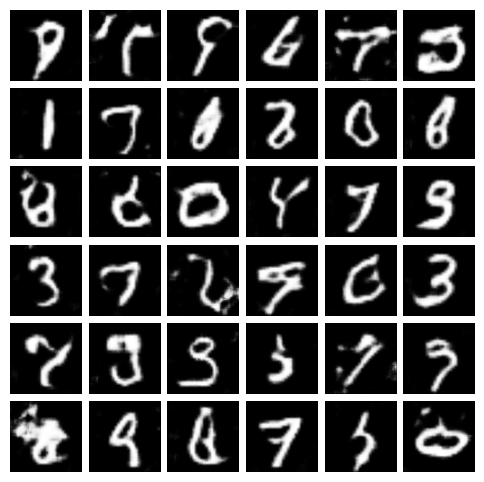

In [ ]:
samples = model.sample(36, device=DEVICE)
fig, ax = plt.subplots(6, 6, figsize=(6, 6))
ax = ax.flatten()
for i in range(36):
    ax[i].imshow(samples[i], cmap="gray")
    ax[i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Training loop

## CIFAR10

We train a WGAN follwoing the same hyperparameters as before. The results are shown below. Note that WGAN seems to be generating images of car and animals. 

In [ ]:
model = WGAN(weight_init=True).to(DEVICE)
optimizerD = optim.RMSprop(model.discriminator.parameters(), lr=0.0002)
optimizerG = optim.RMSprop(model.generator.parameters(), lr=0.0002)
train(model, train_loader, optimizerD, optimizerG, epochs=10)

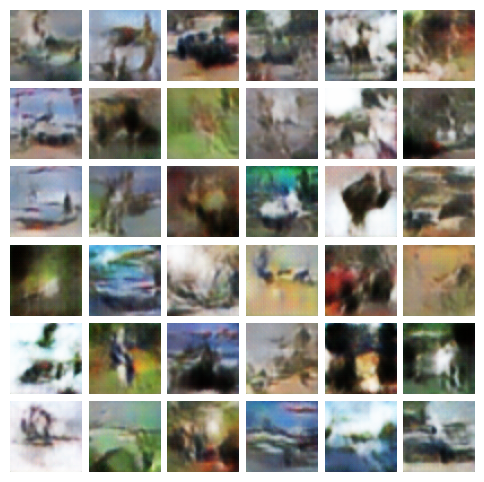

In [ ]:
def plot_samples(n_samples):
    model.eval()
    samples = model.sample(36, device=DEVICE)
    fig, ax = plt.subplots(6, 6, figsize=(6, 6))
    ax = ax.flatten()
    for i in range(36):
        ax[i].imshow(samples[i])
        ax[i].axis("off")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()